In [1]:
workspace_dir = './data'

from torch.utils.data import Dataset, DataLoader
import cv2
import os

class FaceDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(fname)
        img = self.BGR2RGB(img) #because "torchvision.utils.save_image" use RGB
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

import glob
import torchvision.transforms as transforms

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # resize the image to (64, 64)
    # linearly map [0, 1] to [-1, 1]
    transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((64, 64)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3) ] )
    dataset = FaceDataset(fnames, transform)
    return dataset

提供random seed的函数，以便reproduce

In [2]:
import random
import torch
import numpy as np

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    np.random.seed(seed)  # Numpy module
    random.seed(seed)  # Python random module
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

### Model
使用DCGAN网络

<img src="DCGAN.png" width="80%">

In [8]:
import torch.nn as nn
import torch.functional as F

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.weight.data.fill_(0)

class Generator(nn.Module):
    """
    input: (n_batch, in_dim)
    output: (n_batch, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(in_dim, dim*8*4*4)
        self.layer2 = self.deconv_bn_relu(dim*8, dim*4)
        self.layer3 = self.deconv_bn_relu(dim*4, dim*2)
        self.layer4 = self.deconv_bn_relu(dim*2, dim)
        self.layer5 = nn.Sequential(
                        nn.ConvTranspose2d(dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
                        nn.Tanh())
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        output = self.layer5(x)
        
        return output
        
    def deconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_dim),
            nn.ReLU())
    
class Discriminator(nn.Module):
    """
    input: (n_batch, 3, 64, 64)
    output: (n_batch, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        self.layer1 = self.conv_bn_lrrelu(in_dim, dim)
        self.layer2 = self.conv_bn_lrrelu(dim, dim*2)
        self.layer3 = self.conv_bn_lrrelu(dim*2, dim*4)
        self.layer4 = self.conv_bn_lrrelu(dim*4, dim*8)
        self.layer5 = nn.Sequential(
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid())
        self.apply(weights_init)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        output = x.view(-1)
        
        return output
        
    def conv_bn_lrrelu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 5, 2, 2),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2))

In [9]:
import torch
from torch import optim
from torch.autograd import Variable
import torchvision

# hyperparameters 
batch_size = 64
z_dim = 100
lr = 1e-4
n_epoch = 100
save_dir = os.path.join(workspace_dir, 'logs')
os.makedirs(save_dir, exist_ok=True)

# model
G = Generator(in_dim=z_dim).cuda()
D = Discriminator(3).cuda()
G.train()
D.train()

# loss criterion
criterion = nn.BCELoss()

# optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))


same_seeds(0)
# dataloader (You might need to edit the dataset path if you use extra dataset.)
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


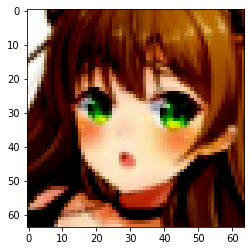

In [10]:
# 隨便印一張圖看看
import matplotlib.pyplot as plt
plt.imshow(dataset[10].numpy().transpose(1,2,0))

Epoch [1/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_001.jpg.


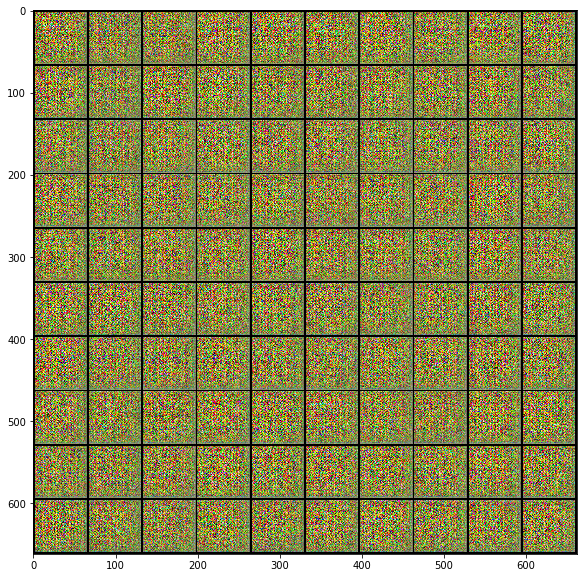

Epoch [2/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_002.jpg.


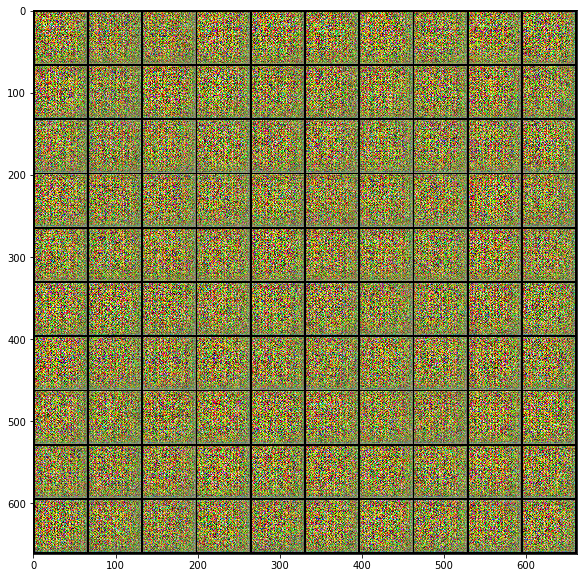

Epoch [3/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_003.jpg.


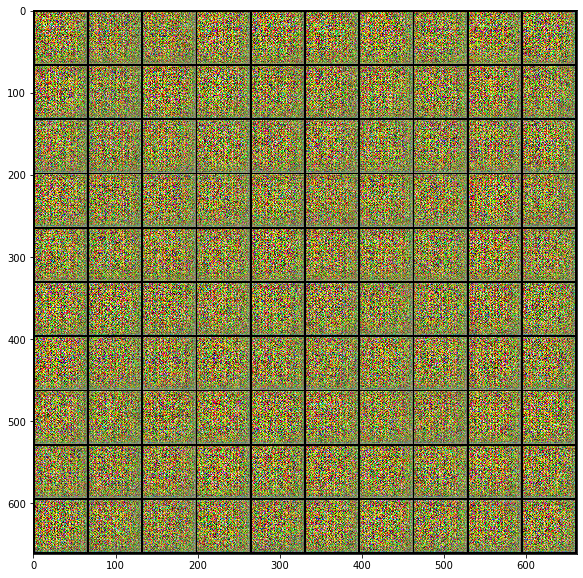

Epoch [4/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_004.jpg.


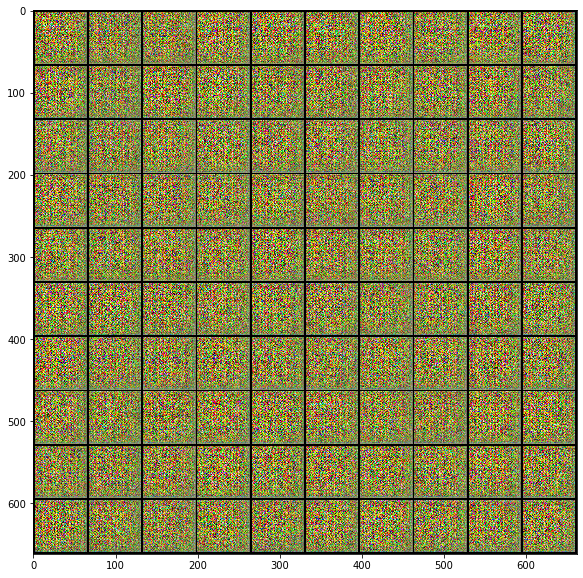

Epoch [5/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_005.jpg.


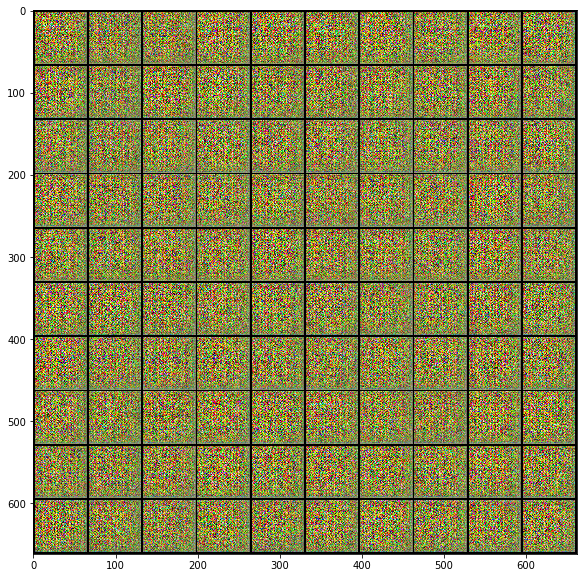

Epoch [6/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_006.jpg.


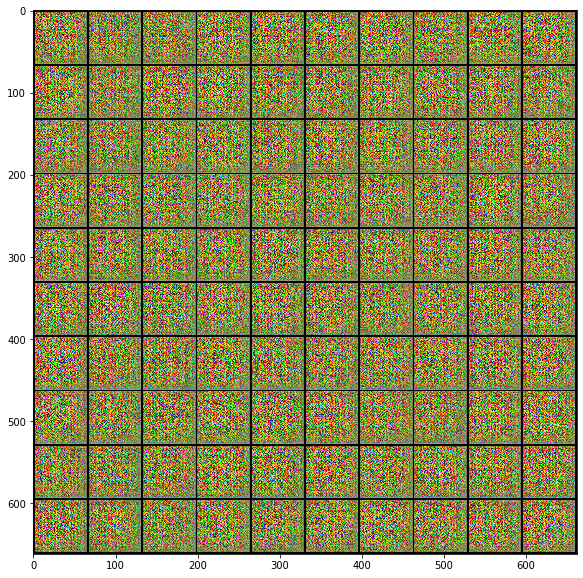

Epoch [7/100] 1115/1115 Loss_D: 0.6931 Loss_G: 0.6931 | Save some samples to ./data/logs/Epoch_007.jpg.


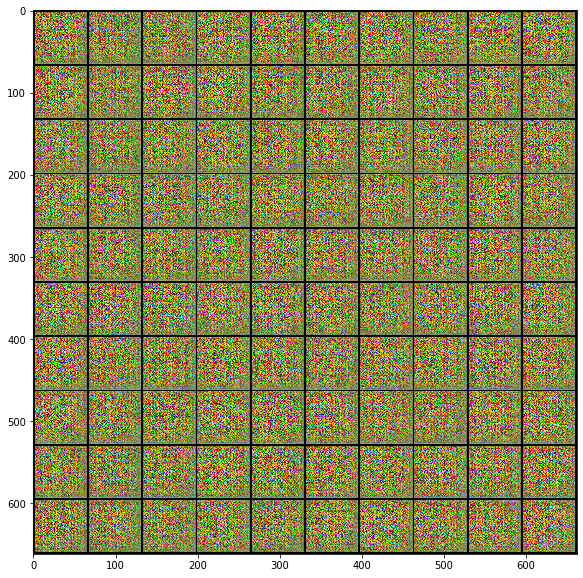

Epoch [8/100] 15/1115 Loss_D: 0.6931 Loss_G: 0.6931

In [ ]:
# for logging
z_sample = Variable(torch.randn(100, z_dim)).cuda()

for e, epoch in enumerate(range(n_epoch)):
    for i, data in enumerate(dataloader):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        """ Train D """
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs = G(z)

        # label        
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # dis
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        
        # compute loss
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # update model
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        """ train G """
        # leaf
        z = Variable(torch.randn(bs, z_dim)).cuda()
        f_imgs = G(z)

        # dis
        f_logit = D(f_imgs)
        
        # compute loss
        loss_G = criterion(f_logit, r_label)

        # update model
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{n_epoch}] {i+1}/{len(dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(save_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    # show generated image
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()
    if (e+1) % 5 == 0:
        torch.save(G.state_dict(), os.path.join(workspace_dir, f'dcgan_g.pth'))
        torch.save(D.state_dict(), os.path.join(workspace_dir, f'dcgan_d.pth'))

In [ ]:
import torch
# load pretrained model
G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(workspace_dir, 'dcgan_g.pth')))
G.eval()
G.cuda()

In [ ]:
# generate images and save the result
n_output = 20
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
save_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(save_dir, f'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)
# show image
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [23]:
torch.cuda.is_available()


True